# Initialise 

Initialise notebook with required library imports and set random state

In [1]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")

!pip install noisereduce
import noisereduce as nr
import sys
import os
import imp as sp
import math
import random
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import normalize
import librosa
import librosa.display
from matplotlib import pyplot as plt
from pyarrow import feather 
!pip install pyarrow
%cd "/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/"
%pwd
rs=87
folder ="Features/TIME"
pd.arrays.IntegerArray.__arrow_array__ = lambda self, type: pyarrow.array(self._data, mask=self._mask, type=type)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition


#Helper Functions

In [2]:
def load_dataset(dataset,duration, fs, offset):
    time_data = []
    total_len = math.floor((duration-offset)*fs)
    fade_len = round(int(fs / 64))
    fade_leno=round(int(fs / 32))
    fade_in = np.linspace(0.0, 1.0, fade_len)
    fade_out = np.linspace(1.0, 0.0, fade_leno)
    for i, path, in enumerate(dataset.Path):
        x, fs = librosa.load(path, res_type='kaiser_fast', duration=duration, sr=fs, offset=offset)
        x[0:fade_len] = x[0:fade_len] * fade_in
        x[x.size-fade_leno:x.size] = x[x.size-fade_leno:x.size] * fade_out
        x = np.expand_dims(x, axis=1)
        norm_x = sklearn.preprocessing.normalize(x, norm='max', axis=0)
        trim_X = remove_silence(norm_x, fs, 0.001)
        trim_x = trim_X.flatten()
        denoise_x = nr.reduce_noise(trim_x, sr = fs, prop_decrease=0.99)
        
        if total_len > len(denoise_x - 1):
            pad_x = np.pad(denoise_x, (0, total_len - len(denoise_x)), 'constant')
        else:
            pad_x = denoise_x[0:total_len]
        fin_x=np.array(pad_x).astype('float64')
        time_data.append(fin_x)
    
  
    np.nan_to_num(time_data, nan=0)
    time_data = np.asarray(time_data).astype('float64')
    np.nan_to_num(time_data, nan=0)
    labels = dataset
    features = time_data
    return features, labels


In [3]:
def remove_silence(x, fs, thresh):
    frame_size = round(0.1*fs)
    N = len(x)
    nframes = round(N/frame_size)
    x_sil = []
    inx1= 1
    inx2 = 0
    for i in range(nframes):
        frame = x[((inx1-1)*frame_size+1) : (frame_size*inx1)]
        inx1 = inx1 + 1
        maximum = np.max(frame)

        if maximum > thresh:
            inx = inx2+1
            x_sil[(inx2-1)*frame_size+1 : frame_size*inx2] = frame

    x_sil = np.array(x_sil)

    return x_sil



def plot_mel_spec(y, sr, n_fft, hop_length, win_length, title):  
    fig, ax = plt.subplots()                                           
    M = librosa.feature.melspectrogram(y=y, sr = fs, n_fft = Nfft, 
                                                    hop_length = hop_len, 
                                                    win_length = win_len, n_mels = 128,
                                                    window = 'hann', fmax = 8000 )
    M_db = librosa.power_to_db(M, ref=np.max)
    img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax, hop_length=hop_len)
    ax.set(title=title)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    plt.show()

def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-10, high = 10)*500)
    data = np.roll(data, s_range,)

    return data

def noise(data):
    """
    Adding White Noise.
    """
  
    RMS=math.sqrt(np.mean(data**2))  
    noise=np.random.normal(0, RMS, data.shape)                   
    data = data + 0.02*noise


    return data





# Extract Time data

This notebook uses the dataset meta files to extract raw time data from datasets.



## Dataset Info

In [4]:
dataset = 'CREMA'
ds_name = dataset
load_path = os.path.join(os.getcwd(),'Dataset Meta',dataset+'.csv')

duration = 3
fs = 16000
offset = 0

# Setting FFT params for mel spec images
Nfft = 512        # FFT Length
win_len_ms = 25   # Window Length in ms
hop_len_ms = 10   # Hop Size in ms

# Converting ms to samples
win_len = int((fs/1000) * win_len_ms)
hop_len = int((fs/1000) * hop_len_ms)



## Load and Save
Reads the dataset meta file

In [5]:

data = pd.read_csv(load_path)
data.dropna(axis=0, how="any", thresh=None, inplace=True)

# data = data[0:3]



### Clean Data

In [6]:


X_clean, y_clean = load_dataset(dataset=data, duration=duration, 
                     fs=fs, offset=offset)
X_clean = np.array(X_clean).astype('float64')
labels = pd.DataFrame(y_clean)
time = pd.DataFrame(X_clean).astype('float64')
clean_df = pd.concat([labels, time], axis=1)
clean_df.dropna(axis=0, how="any", thresh=None, inplace=True)

/usr/local/lib/python3.7/dist-packages/noisereduce/noisereduce.py:303: RuntimeWarning: invalid value encountered in true_divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


Saving Clean time data to: /content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/Features/TIME/CREMA/Clean_CREMA_16000.csv




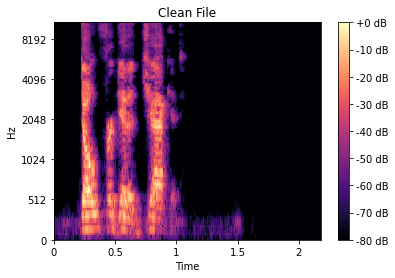

In [7]:
name = "Clean"
if not os.path.isdir(os.path.join(os.getcwd(), folder, ds_name)):
    os.makedirs(os.path.join(os.getcwd(), folder, ds_name))

save_path = os.path.join(os.getcwd(), folder, ds_name, name+"_"+ds_name+'_'+str(fs)+'.csv')
print(f"Saving {name} time data to: {save_path}\n\n")
clean_df.to_csv(save_path)

y1 = clean_df.iloc[:, 7:] 
y1 = np.array(y1)
plot_mel_spec(y=y1[0], sr = fs, n_fft = Nfft, 
                                                hop_length = hop_len, 
                                                win_length = win_len, title = "Clean File")

clean_df.head()
clean_df=None

In [8]:
# clean_df = pd.read_csv(save_path)
# clean_df=None

### Shifted Data

Data augmentation by shifting the signal both forwards and backwards

In [9]:
# labels = pd.DataFrame(y_clean)
# time = shift(X_clean)
# time = pd.DataFrame(time).astype('float64')
# shifted_df = pd.concat([labels, time], axis=1)
# shifted_df.dropna(axis=0, how="any", thresh=None, inplace=True)
# y2 = shifted_df.iloc[:, 7:] 
# y2 = np.array(y2)
# plot_mel_spec(y=y2[0], sr = fs, n_fft = Nfft, 
#                                                 hop_length = hop_len, 
#                                                 win_length = win_len, title = " Shifted File")
# shifted_df.head()

In [10]:
# name = 'Shifted'

# if not os.path.isdir(os.path.join(os.getcwd(), folder, ds_name)):
#     os.makedirs(os.path.join(os.getcwd(), folder, ds_name))

# save_path = os.path.join(os.getcwd(), folder, ds_name, name+"_"+ds_name+'_'+str(fs)+'.csv')
# print(f"Saving {name} time data to: {save_path}\nn")
# shifted_df.to_csv(save_path)
# shifted_df = None


### Noisey Data

Data augmentation by adding randomly distributed noise

In [11]:
# labels = pd.DataFrame(y_clean)
# time = noise(X_clean)
# time = pd.DataFrame(time).astype('float64')


# noisey_df = pd.concat([labels, time], axis=1)
# noisey_df.dropna(axis=0, how="any", thresh=None, inplace=True)



# y3 = noisey_df.iloc[:, 7:] 
# y3 = np.array(y3)
# plot_mel_spec(y=y3[0], sr = fs, n_fft = Nfft, 
#                                                 hop_length = hop_len, 
#                                                 win_length = win_len, title = " Noisey File")

# noisey_df.head()

In [12]:
# name = 'Noisey'

# if not os.path.isdir(os.path.join(os.getcwd(), folder, ds_name)):
#     os.makedirs(os.path.join(os.getcwd(), folder, ds_name))

# save_path = os.path.join(os.getcwd(), folder, ds_name, name+"_"+ds_name+'_'+str(fs)+'.csv')
# print(f"Saving {name} time data to: {save_path}\nn")
# noisey_df.to_csv(save_path)
# noisey_df = None

### Shifted & Noisey Data

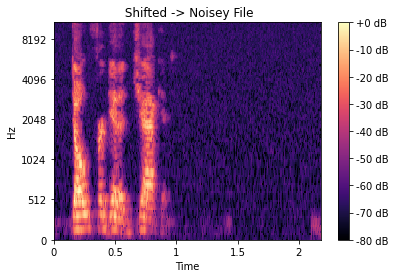

,Labels,Source,Actor ID,Path,Gender,Emotion,Polarity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,47960,47961,47962,47963,47964,47965,47966,47967,47968,47969,47970,47971,47972,47973,47974,47975,47976,47977,47978,47979,47980,47981,47982,47983,47984,47985,47986,47987,47988,47989,47990,47991,47992,47993,47994,47995,47996,47997,47998,47999
0,male_angry,CREMA,1001,/content/drive/MyDrive/Colaboratory/SERv2/Data...,male,angry,neg,0.002438,0.002523,0.001082,0.000701,0.000805,0.000926,0.000759,0.000412,0.002190,0.000652,0.001710,-0.000573,0.000620,-0.000097,0.000683,0.002264,0.001006,-0.000388,0.000513,0.001906,0.001064,-0.000792,-0.000010,-0.000831,-0.001311,-0.001491,-0.000452,-0.000060,-0.000895,-0.001405,-0.001614,0.000488,-0.001421,...,0.003252,0.003306,0.002367,0.001144,0.000953,-0.000396,0.001345,0.005046,0.001598,0.000262,0.000922,0.002400,-0.000113,0.000134,0.001198,-0.000753,0.000500,0.000850,0.001340,-0.000086,0.001501,0.001027,-0.001909,0.000164,-0.000362,0.001447,0.001296,0.000578,-0.001006,-0.000179,-0.002870,-0.001040,-0.000330,0.000181,-0.000127,0.002178,0.000501,0.003136,0.002310,0.001980
1,male_disgust,CREMA,1001,/content/drive/MyDrive/Colaboratory/SERv2/Data...,male,disgust,neg,0.000311,0.000734,-0.000141,0.001726,0.001061,0.000695,0.001551,-0.000084,0.000617,-0.000356,0.002401,0.002518,0.001422,0.000553,-0.000102,0.000476,0.001073,0.000458,-0.000781,0.001810,0.002571,0.001370,0.002566,0.001341,0.000226,-0.000138,0.001279,0.003193,0.000428,-0.000906,0.001065,0.001131,-0.000900,...,0.000935,0.001033,0.000097,-0.001159,0.000267,-0.000162,0.002993,0.000414,0.000605,-0.001211,0.000346,0.000884,-0.000865,-0.000181,-0.001536,-0.000873,0.002275,-0.000960,-0.000722,0.002852,0.002695,0.000035,0.000624,0.000694,0.001540,0.000497,-0.001791,-0.000423,0.000155,0.000661,0.001984,-0.000865,0.000504,-0.000596,-0.001531,-0.002156,-0.000233,-0.001586,-0.000698,-0.000140
2,male_fear,CREMA,1001,/content/drive/MyDrive/Colaboratory/SERv2/Data...,male,fear,neg,-0.001987,0.000687,0.000922,0.000106,0.000861,-0.002236,0.000984,0.002220,0.000320,0.001521,-0.000523,-0.000765,-0.000871,-0.000939,-0.001245,-0.001001,0.000658,-0.002202,0.000999,0.000668,0.000430,-0.000677,-0.001444,0.000585,0.000225,-0.001470,0.000053,0.001004,-0.001173,-0.000554,-0.003085,0.000122,-0.001349,...,0.000923,0.001691,-0.001231,-0.002208,-0.000210,0.000873,0.002797,-0.000304,-0.000048,0.000506,0.000818,-0.000655,0.001081,-0.000761,-0.000173,-0.000175,-0.002951,0.000465,0.003257,-0.000472,0.001805,-0.001434,0.000394,0.002809,0.000146,0.002406,0.001341,0.001506,-0.000293,0.000933,0.000086,-0.000248,-0.000476,-0.001604,0.002714,0.002105,0.000638,0.001710,0.001136,-0.001141
3,male_happy,CREMA,1001,/content/drive/MyDrive/Colaboratory/SERv2/Data...,male,happy,pos,0.000358,0.000472,-0.000436,-0.002200,0.000072,-0.000048,0.000014,-0.000031,0.001063,0.001933,-0.000793,-0.001209,-0.001102,0.002330,-0.003431,-0.003192,-0.002554,-0.001761,0.000026,-0.002053,0.001559,-0.002211,-0.001453,0.001331,-0.001810,-0.002313,-0.001290,-0.001572,-0.000363,-0.000501,-0.000929,-0.001789,-0.002740,...,0.003046,0.001313,0.001575,-0.000804,0.000828,0.001036,-0.000673,0.001724,0.001385,0.000324,0.001117,0.002958,0.002208,0.001279,0.000525,0.001889,-0.000058,0.002509,-0.001724,0.001346,0.000124,0.003067,0.002428,0.001091,-0.001061,-0.002224,0.000141,-0.001790,0.000539,0.000869,-0.000240,-0.000715,-0.000963,-0.000542,-0.001849,0.000111,-0.000336,0.000296,-0.002138,0.000910
4,male_neutral,CREMA,1001,/content/drive/MyDrive/Colaboratory/SERv2/Data...,male,neutral,neut,-0.003380,-0.001740,0.001098,-0.000764,0.000211,-0.002221,-0.000346,-0.001552,-0.000444,0.001553,-0.001496,-0.000306,-0.000910,-0.000210,-0.001455,-0.003916,-0.000337,-0.001444,-0.001972,-0.000624,0.000131,-0.003151,-0.000892,-0.000945,-0.001071,-0.001237,-0.000851,0.001089,-0.000721,0.000091,-0.000671,0.001106,-0.001227,...,0.000330,0.000222,0.002790,0.003305,-0.001081,0.001185,0.001764,0.00

In [13]:

labels = pd.DataFrame(y_clean)
time = shift(X_clean)
time = noise(time)
time = pd.DataFrame(time)
shifted_noisey_df = pd.concat([labels, time], axis=1)
shifted_noisey_df.dropna(axis=0, how="any", thresh=None, inplace=True)

y4 = shifted_noisey_df.iloc[:, 7:] 
y4 = np.array(y4)
plot_mel_spec(y=y4[0], sr = fs, n_fft = Nfft, 
                                                hop_length = hop_len, 
                                                win_length = win_len, title = " Shifted -> Noisey File")


shifted_noisey_df.head()


In [14]:
name = 'Shifted_Noisey'

if not os.path.isdir(os.path.join(os.getcwd(), folder, ds_name)):
    os.makedirs(os.path.join(os.getcwd(), folder, ds_name))
save_path = os.path.join(os.getcwd(), folder, ds_name, name+"_"+ds_name+'_'+str(fs)+'.csv')
print(f"Saving {name} time data to: {save_path}\nn")
shifted_noisey_df.to_csv(save_path)
shifted_noisey_df=None

Saving Shifted_Noisey time data to: /content/drive/My Drive/Colaboratory/Speech Emotion Recognition/Features/TIME/CREMA/Shifted_Noisey_CREMA_16000.csv
n


## Images

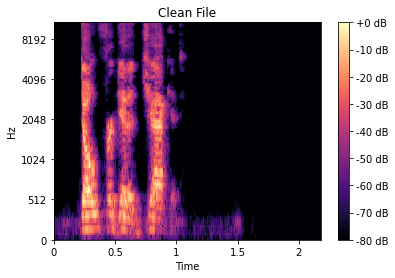

NameError: ignored

In [15]:

                                                

plot_mel_spec(y=y1[0], sr = fs, n_fft = Nfft, 
                                                hop_length = hop_len, 
                                                win_length = win_len, title = "Clean File")

plot_mel_spec(y=y2[0], sr = fs, n_fft = Nfft, 
                                                hop_length = hop_len, 
                                                win_length = win_len, title = " Shifted File")
plot_mel_spec(y=y3[0], sr = fs, n_fft = Nfft, 
                                                hop_length = hop_len, 
                                                win_length = win_len, title = " Noisey File")

plot_mel_spec(y=y4[0], sr = fs, n_fft = Nfft, 
                                                hop_length = hop_len, 
                                                win_length = win_len, title = " Shifted -> Noisey File")

# M = librosa.feature.melspectrogram(y=noisey.Features[0], sr = fs, n_fft = Nfft, 
#                                                 hop_length = hop_len, 
#                                                 win_length = win_len, n_mels = 128,
#                                                 window = 'hann', fmax = 8000 )
